In [1]:
import torch

from transformers import PreTrainedModel
from trader_models import SGConvConfig, SGConvTrader
import datasets
from datasets import load_dataset, Dataset, DatasetDict

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

import numpy as np

import logging
logging.disable(logging.INFO)

In [2]:
def compute_metrics(preds):
    soft_profit, soft_trade = preds.predictions
    abs_trade = np.abs(soft_trade)
    abs_trade = abs_trade.astype('float64') # half precision will cause the sum to overflow on next line
    trades = abs_trade.sum()
    
    day_profits = soft_profit.sum(axis = (1, 2))
    
    metrics = {
        'day profit': day_profits.mean(),
        'day sharpe': day_profits.mean() / day_profits.std(),
        'trade %': trades * 100 / soft_profit.size,
        
        'full trade %': (abs_trade >= .7).mean() * 100,
        'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
        'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
                          / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
        
        'medium trade %': ((abs_trade < .7) & (abs_trade >= .4)).mean() * 100,
        'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
        'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),       
        
        'small trade %': ((abs_trade < .4) & (abs_trade >= .2)).mean() * 100,
        'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
        'small trade g/l': soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit < 0)].mean(),        
    }
    
    # round the metrics
    metrics = {k: np.format_float_positional(v, precision = 4) for k, v in metrics.items()}
    
    return metrics

In [3]:
fx = Dataset.load_from_disk('data/fx_days')

# make splits
split = fx.train_test_split(.003, shuffle = False)
# split = fx.train_test_split(.0015, shuffle = False)
valid_test = split['test'].train_test_split(.3, shuffle = False)
fx = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [4]:
fx

DatasetDict({
    train: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 35213
    })
    validation: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 74
    })
    test: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 32
    })
})

In [5]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 200,
    eval_steps = 200,
    save_steps = 10000,
    report_to = "none",
    learning_rate = 2e-4,
    weight_decay = .01,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    max_grad_norm = 1,
#     fp16 = True,
)

In [6]:
config = SGConvConfig(
    n_embd = 320, n_head = 1, hidden_dropout_prob = 0
)

model = SGConvTrader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

Using 13 layers


# Interesting Experiment on loss function

This model uses a particularly interesting loss function which is to maxmize mean gain / mean loss (i.e. a profitability ratio) though losses are weighted 2x. This has some desireable properties like that it is 1. volitility agnostic (doesn't favor low or high volitility) and 2. closely matches trying to create the most profit for the least risk.

As we can see it is able to acheve a massive 21% trades at 54% accuracy (which is completely unseen before) very early in training. Unfortunetly it suffers from an issue where instead of trying to turn all losses in to profits, it'll end up just trying to get losses as close to 0 as possible. I hypothesize that if a loss function can have the same original properties as this one without introducing odd inductive biases, it could easily get 10% of trades above 66% when fully trained

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss, losses 2x (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.931200,1.926929,0.0520,0.1246,25.6956,2.7233,52.2015,1.0196,17.8804,50.6467,0.9908,34.5888,49.9466,1.0133
400,1.879100,1.890123,0.0842,0.1209,36.6114,14.7138,49.3165,0.9972,24.4749,50.4806,0.9753,26.7429,50.943,1.0198
600,1.730700,1.659309,0.2349,0.4443,19.8502,10.8074,53.6272,1.2617,5.6224,51.4753,1.0386,8.5016,49.8908,0.9994
800,1.617100,1.521395,0.3337,0.3548,29.7141,21.3043,54.0425,1.1447,7.1844,50.0501,0.9862,8.6662,48.6163,0.9462
1000,1.511700,1.304314,0.2701,0.3904,13.0267,7.9798,57.4919,1.1768,3.535,54.7106,0.9572,4.3138,52.5513,0.9480
1200,1.463900,1.327118,0.1898,0.3623,12.4044,7.5620,55.7713,1.1685,3.6159,50.3374,0.9847,3.8146,50.6424,0.9883
1400,1.436200,1.395933,0.2121,0.3324,16.9442,12.2026,52.8267,1.1691,3.7334,50.5348,1.0332,3.7505,51.4165,1.0371
1600,1.447000,1.452734,0.0248,0.1016,6.8664,3.6950,50.7097,0.9809,1.7609,47.3176,1.043,2.2978,50.5468,0.9641
1800,1.450800,1.370238,0.0894,0.4092,7.3327,3.8766,55.9229,1.2147,2.2341,50.0467,0.9963,2.3319,47.7419,0.9980
2000,1.445800,1.336127,0.0579,0.2298,8.4095,5.1978,52.2819,1.0553,2.3649,48.5185,1.0457,2.4887,49.7779,1.0324


TrainOutput(global_step=8804, training_loss=1.2161343785536824, metrics={'train_runtime': 2875.508, 'train_samples_per_second': 12.246, 'train_steps_per_second': 3.062, 'total_flos': 0.0, 'train_loss': 1.2161343785536824, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.968200,0.947759,0.0501,0.1156,26.0528,4.3777,49.6784,1.053,16.7949,50.0875,1.0033,32.2314,49.3976,1.0166
400,0.934200,0.952670,0.0651,0.0901,36.5554,15.2807,48.8911,0.9586,23.9898,50.2851,0.9727,25.6584,51.1110,1.03
600,0.864400,0.819264,0.2321,0.4685,18.7678,10.0807,53.6958,1.2813,5.1913,52.5418,1.0114,7.7154,50.3473,0.9773
800,0.801500,0.721963,0.2942,0.3882,21.9927,13.7199,55.043,1.1637,5.8127,52.6208,1.0421,8.3941,48.9236,0.96
1000,0.756800,0.654370,0.3002,0.381,15.4652,10.2951,56.5114,1.1758,3.6271,52.6779,0.9861,4.8654,52.1935,0.9190
1200,0.730900,0.681203,0.1976,0.3889,13.0798,7.2069,56.0282,1.2104,3.8606,50.8008,1.04,4.702,51.0600,0.9603
1400,0.723200,0.646497,0.1886,0.3773,12.8167,8.6397,54.2265,1.2455,3.1383,49.4418,0.9981,3.6688,51.0473,0.9778
1600,0.723800,0.827965,0.001,0.0035,7.4842,4.1659,48.9525,0.9522,1.569,47.1988,0.8918,1.9683,50.6754,0.9726
1800,0.744000,0.756372,0.0556,0.3281,4.6308,1.8173,55.5454,1.1778,1.0443,52.5112,1.0336,1.7374,50.8822,1.0006
2000,0.729500,0.665394,0.0686,0.2741,6.6985,3.5642,53.2385,1.1463,2.1139,48.9913,1.0414,2.304,50.8056,1.0239


TrainOutput(global_step=8804, training_loss=0.6076698233354422, metrics={'train_runtime': 3418.1337, 'train_samples_per_second': 10.302, 'train_steps_per_second': 2.576, 'total_flos': 0.0, 'train_loss': 0.6076698233354422, 'epoch': 1.0})

In [8]:
trainer.evaluate(fx['test'])

{'eval_loss': 1.7025059461593628,
 'eval_day profit': '0.0661',
 'eval_day sharpe': '0.5309',
 'eval_trade %': '8.2851',
 'eval_full trade %': '1.3026',
 'eval_full trade accuracy': '9.4595',
 'eval_full trade g/l': '2.8037',
 'eval_medium trade %': '1.1709',
 'eval_medium trade accuracy': '68.9662',
 'eval_medium trade g/l': '1.4940',
 'eval_small trade %': '3.493',
 'eval_small trade accuracy': '61.0659',
 'eval_small trade g/l': '1.0435',
 'eval_runtime': 2.1841,
 'eval_samples_per_second': 14.651,
 'eval_steps_per_second': 3.663,
 'epoch': 1.0}

In [8]:
model_name = 'sqconv_raw.model'
trainer.save_model(model_name)

# quick prediction test to ensure model isn't cheating

In [9]:
config = SGConvConfig(
    n_embd = 320, n_head = 1, hidden_dropout_prob = 0
)
model = SGConvTrader.from_pretrained(model_name, config = config, ignore_mismatched_sizes=True).cuda().eval()

Using 13 layers


0
tensor([-0.0257, -0.0132, -0.0076, -0.0249,  0.0175, -0.0234, -0.0048,  0.0026,
        -0.0191])


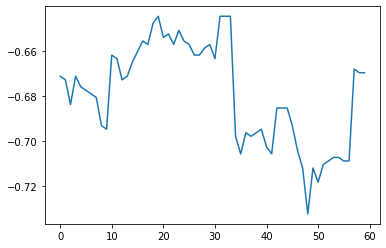

1
tensor([ 3.5118e-02,  2.6283e-02, -2.4536e-02,  6.2625e-02, -2.8070e-04,
        -2.2268e-01, -2.5588e-01, -3.8412e-01, -4.5883e-01])


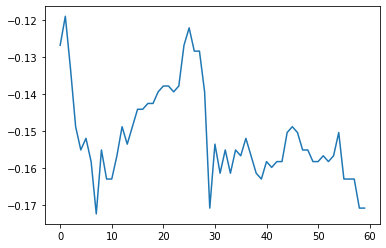

2
tensor([ 0.0920, -0.0433, -0.0012,  0.0656,  0.0100, -0.0220,  0.0235,  0.0310,
         0.0280])


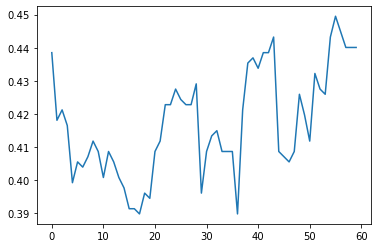

3
tensor([ 0.0243,  0.0728,  0.0025,  0.0273, -0.0455, -0.1555, -0.1298, -0.0893,
        -0.1602])


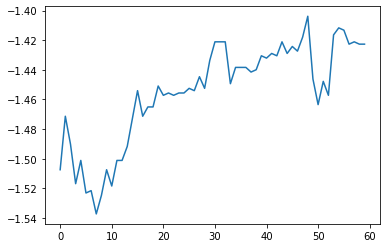

4
tensor([-0.0907, -0.1053, -0.3088, -0.2540, -0.3148, -0.7390, -0.7282, -0.4338,
        -0.2508])


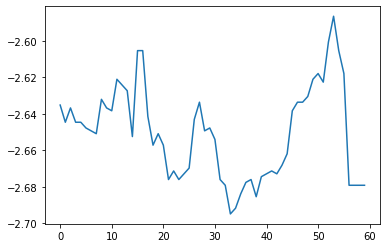

5
tensor([-0.0098,  0.0283, -0.0867, -0.1492,  0.3091, -0.0040,  0.1885,  0.2064,
         0.2083])


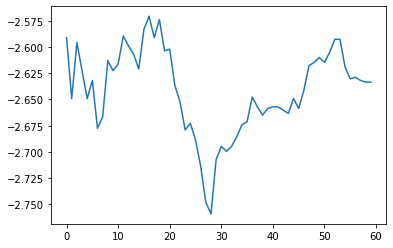

6
tensor([-0.0002, -0.0566, -0.0184, -0.0087, -0.0452, -0.0060, -0.0095,  0.0134,
        -0.0255])


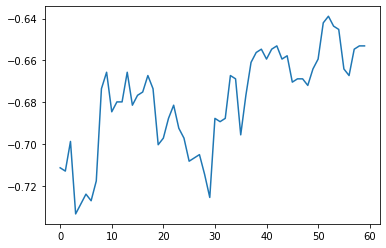

7
tensor([ 0.1049, -0.1839, -0.1614, -0.2898, -0.4136, -0.1853, -1.0820,  0.0228,
        -0.5383])


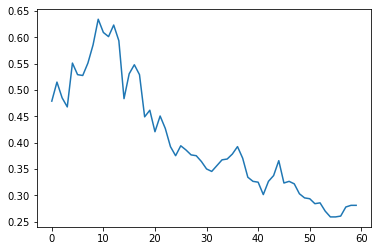

8
tensor([-99.5010, -99.4361, -99.6603, -99.4261, -99.8748, -99.4784, -99.5205,
        -98.9463,  99.8487])


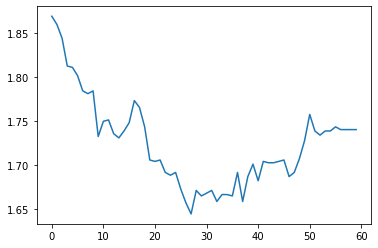

9
tensor([-0.0240,  0.0137, -0.0089, -0.0115, -0.0052,  0.0093, -0.0056, -0.0569,
        -0.0514])


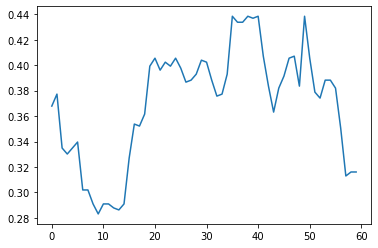

In [12]:
import matplotlib.pyplot as plt

for day in range(10):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:]).unsqueeze(0).cuda()
    test_futures = torch.tensor(fx['validation']['future'][day][:]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][21*60:22*60])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day)[0][21*60]
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
        print((pred.cpu() * 100))
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

0
tensor([-0., -0., -0., -0., 0., -0., -0., 0., -0.])


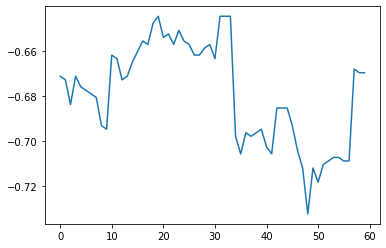

1
tensor([0., 0., -0., 0., -0., -0., -0., -0., -0.])


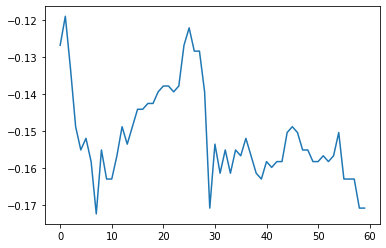

In [11]:
import matplotlib.pyplot as plt

for day in range(2):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:21*60 + 1]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][21*60:22*60])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day)[0][-1]
        
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
#         plt.pcolormesh(pred.cpu().unsqueeze(0))
        plt.show()
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

# TODO: graph these instead of showing raw data (maybe even on same plot or at least side by side)

In [14]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)
soft_profit, soft_trade = trainer.predict(fx['validation']).predictions

In [15]:
(soft_profit.sum(axis = (1, 2)) < 0).mean()

0.32432432432432434

In [16]:
soft_profit.sum(axis = (1, 2)).std()

0.11143883

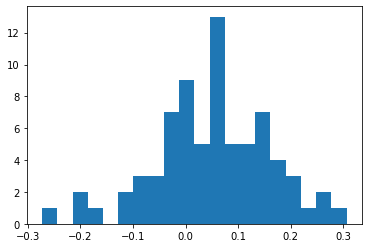

In [17]:
import matplotlib.pyplot as plt

plt.hist(soft_profit.sum(axis = (1, 2)), bins = 20)
plt.show()

In [19]:
# full trade percent on 24 hours
(((np.abs(soft_trade) > .2) & (np.abs(soft_trade) < 10)).mean(axis = (0, 2)).reshape(-1, 60).mean(axis = 1) * 100).round()

array([ 5.,  0.,  0.,  3.,  5.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  2., 12., 51., 63., 21.])

In [20]:
# full trade accuracy on 24 hours
np.nanmean(np.where(((np.abs(soft_trade) > .2) & (np.abs(soft_trade) < 10)), soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-20-f6be64cbd057>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(((np.abs(soft_trade) > .2) & (np.abs(soft_trade) < 10)), soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([       nan,        nan,        nan, 0.56027644, 0.53576666,
       0.53156235,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.55270133, 0.59862689, 0.53907986, 0.36340438])

In [21]:
# full trade profit on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-21-e15bc04a1bb7>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([            nan,             nan,             nan,  1.19459346e-05,
       -1.50452900e-06,  1.25091155e-05,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -5.69391432e-06,  2.98715604e-05,  6.57019045e-05,  1.34570055e-05],
      dtype=float32)

In [22]:
# percent full trades on all timeframes
(np.abs(soft_trade) > .3).mean(axis = (0, 1))

array([0.03007695, 0.03849474, 0.04355293, 0.0473536 , 0.05259009,
       0.05819257, 0.05682245, 0.04026839, 0.02685811])

In [23]:
# full trade accuracy on all timeframes
np.nanmean(np.where(np.abs(soft_trade) > .3, soft_profit > 0, np.nan), axis = (0, 1))

array([0.30826833, 0.4141882 , 0.46907994, 0.49762188, 0.5442541 ,
       0.56684406, 0.57175888, 0.57772081, 0.56079665])

In [24]:
# full trade gain on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit > 0), soft_profit, np.nan), axis = (0, 1))

array([9.3517876e-05, 1.1040257e-04, 1.2627446e-04, 1.3709566e-04,
       1.4370347e-04, 1.5203208e-04, 1.7406879e-04, 2.0122110e-04,
       2.4339784e-04], dtype=float32)

In [25]:
# full trade loss on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit < 0), soft_profit, np.nan), axis = (0, 1))

array([-7.33010820e-05, -8.14286104e-05, -8.72624005e-05, -9.02208776e-05,
       -9.90652115e-05, -1.06105064e-04, -1.28709653e-04, -1.66588317e-04,
       -1.84737873e-04], dtype=float32)

In [21]:
# del trainer
# del model
# torch.cuda.empty_cache()

# Appendix

## SGConv Experiments

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss, losses + .1 (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.245500,1.132017,0.1147,0.1439,99.1161,99.4033,49.2069,1.0193,0.0051,46.9388,0.6161,0.0015,85.7143,1.0415


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# log standardized trade loss, losses + 1 (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.103200,0.839063,0.2513,0.1471,99.3798,99.4084,49.635,1.0310,0.0015,64.2857,6.3325,0.0002,100.,nan
400,0.863500,0.838906,0.2515,0.1472,99.4069,99.4101,49.6352,1.0311,0.0001,100.,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:27: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:25: RuntimeWarning: Mean of empty slice.
  'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:26: RuntimeWarning: Mean of empty slice.
  'small trade g/l': soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit > 0)].mean()


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# presquare standardized trade loss, losses + 1 (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,6.435000,3.307872,0.0713,0.1406,99.4052,99.4102,49.0756,1.0153,0.,nan,nan,0.,nan,nan
400,3.366600,3.307817,0.0713,0.1406,99.4094,99.4102,49.0756,1.0153,0.,nan,nan,0.,nan,nan
600,3.363900,3.307807,0.0713,0.1406,99.4099,99.4102,49.0756,1.0153,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:25: RuntimeWarning: Mean of empty slice.
  'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
<ipython-

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# square standardized trade loss, losses + .1 (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.699000,1.281750,0.1500,0.146,98.8801,99.3897,49.2939,1.0234,0.0144,63.0435,0.9882,0.0036,57.1429,0.9437
400,1.292200,1.327885,0.0461,0.1584,98.6804,98.5581,49.1911,1.0050,0.4379,50.5238,1.0331,0.2166,47.2316,0.9886
600,1.255800,1.284796,0.1078,0.2387,99.1283,99.0681,49.3508,1.0119,0.1773,49.2353,1.004,0.0849,47.7887,1.0334
800,1.248600,1.291166,0.1108,0.2360,99.2292,99.1844,49.3861,1.0110,0.1162,50.4488,0.9394,0.0552,47.4480,1.1860


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# square standardized trade loss, 2x losses + 1 (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,26.331900,11.772779,0.0009,0.0031,99.0804,99.0062,49.1585,0.9969,0.2060,48.8866,0.9926,0.1018,50.,0.9637
400,11.396300,11.379965,0.1782,0.1454,99.4101,99.4101,49.4153,1.0243,0.0001,100.,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:25: RuntimeWarning: Mean of empty slice.
  'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:26: RuntimeWarning: Mean of empty slice.
  'small trade g/l': soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:27: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit < 0)].mean(),


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# square standardized trade loss, losses + 1 (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.799400,2.396652,-0.0972,-0.1417,99.3976,99.4102,49.0252,0.9817,0.,nan,nan,0.,nan,nan
400,2.358600,2.396541,-0.0972,-0.1417,99.4083,99.4102,49.0252,0.9817,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:25: RuntimeWarning: Mean of empty slice.
  'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
<ipython-

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss, losses + 1 (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.268300,2.372262,0.0912,0.1450,99.3996,99.4100,49.2785,1.0112,0.0001,0.,nan,0.,nan,nan
400,2.363100,2.372129,0.0913,0.1451,99.4088,99.4101,49.2784,1.0112,0.0001,100.,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:25: RuntimeWarning: Mean of empty slice.
  'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:26: RuntimeWarning: Mean of empty slice.
  'small trade g/l': soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:27: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit < 0)].mean(),
<ipython

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# square standardized trade loss, losses 2x (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,3.929900,3.768107,0.0539,0.1823,31.1271,5.5132,52.5665,1.0714,26.9522,50.1052,0.9845,30.5463,49.3106,0.9902
400,3.740600,3.982159,0.0379,0.0775,39.6059,19.8340,49.9416,0.9768,23.554,49.9327,0.9742,23.3743,50.2068,0.9906
600,3.491600,3.732116,0.0914,0.2277,27.2457,11.4002,50.5067,1.0611,8.3187,51.4202,0.9879,25.8674,49.7704,0.9996
800,3.299800,3.144496,0.1149,0.2531,27.3579,16.784,51.3720,1.0514,7.2662,50.7864,0.9628,11.2447,49.9059,0.9894
1000,2.905900,2.593794,0.2288,0.4867,14.6086,8.0054,56.1537,1.2084,4.0879,53.2024,1.0663,5.1752,52.1881,0.9671
1200,2.928600,2.666212,0.0813,0.2952,13.4875,7.4764,50.1618,1.1143,3.2620,50.8087,1.0125,4.4686,51.7290,1.0173
1400,2.697900,2.789548,0.0596,0.2107,13.5287,9.0544,49.8094,1.0264,2.673,50.2360,1.0262,3.2743,51.1464,1.1130
1600,2.702700,2.993182,0.0090,0.0508,7.9011,4.4768,49.2663,0.9660,1.6485,45.6230,0.9454,2.0215,49.5177,1.0106
1800,2.713400,3.248822,0.0014,0.0049,10.1692,6.1419,49.9363,0.9710,2.5123,48.095,0.9650,3.0488,49.2732,0.9701
2000,2.737300,2.635870,0.0226,0.0877,8.7933,5.4228,50.7797,0.9494,2.4038,50.3058,1.0048,2.5930,49.9759,1.0272


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# square standardized trade loss (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.089100,0.921855,0.0846,0.3101,31.5395,4.8777,53.5155,0.9666,28.745,50.5071,1.0045,30.8576,49.0672,1.0007
400,0.957700,1.017222,0.0324,0.0577,47.1689,28.0160,50.3787,0.974,27.1046,50.0458,0.9672,20.6508,49.4448,0.9794
600,0.922500,0.898547,0.1456,0.3357,39.4345,21.9537,51.3496,1.0159,18.4206,50.0127,0.9686,22.9927,49.9295,0.9695
800,0.897200,0.895997,0.1098,0.2305,31.9419,17.3018,50.2510,1.034,14.2036,50.5190,0.9727,16.9758,50.4782,0.9733
1000,0.825100,0.771203,0.2181,0.4399,23.663,13.9244,53.2556,1.0963,6.5054,50.9513,0.9382,9.3177,50.0660,0.9836
1200,0.802500,0.802199,0.1606,0.3758,26.9651,16.2087,52.1628,1.0717,7.8452,50.1854,0.9403,11.0158,49.4444,0.9443
1400,0.832200,0.799641,0.1071,0.3558,18.0792,9.3398,51.4703,1.0967,5.4627,50.2109,0.9889,7.9180,50.2364,0.9994
1600,0.821700,0.819215,0.0547,0.1941,14.4979,6.3646,52.4763,0.9357,5.5735,50.2451,0.9431,7.8908,50.1784,0.9824
1800,0.760600,0.867052,0.0356,0.1477,14.1493,6.5528,52.9804,0.9447,4.9884,48.9705,0.943,6.8644,49.7357,0.9457
2000,0.780400,0.870831,0.0247,0.0808,13.4398,7.1109,50.5968,0.9568,4.2246,49.6298,0.967,5.6426,50.5830,0.9670


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss, 2x on loss side only
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.935700,1.905045,0.043,0.1037,26.9757,3.9857,51.5095,1.0714,19.4951,50.0524,0.9880,32.2691,49.6753,1.0024
400,1.880300,1.931114,0.0779,0.1075,42.3429,20.9454,49.6229,0.9622,26.7082,50.3436,0.9841,25.3010,50.8463,1.0342
600,1.759700,1.773840,0.2331,0.4087,19.6714,8.9802,53.2941,1.2738,6.174,52.6051,1.0065,12.1319,50.7667,1.0148
800,1.636900,1.504781,0.3095,0.3795,25.4199,15.8807,54.6040,1.1606,7.1482,52.5002,1.0219,10.1815,48.9897,0.9594
1000,1.532700,1.349475,0.2846,0.3836,14.8668,9.2239,57.1676,1.164,3.9307,53.4154,0.9777,5.1829,52.2794,0.9151


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\micha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-56d4e1671c9d>", line 7, in <module>
    trainer.train()
  File "C:\Users\micha\anaconda3\lib\site-packages\transformers\trainer.py", line 1527, in train
    return inner_training_loop(
  File "C:\Users\micha\anaconda3\lib\site-packages\transformers\trainer.py", line 1749, in _inner_training_loop
    for step, inputs in enumerate(epoch_iterator):
  File "C:\Users\micha\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 681, in __next__
    data = self._next_data()
  File "C:\Users\micha\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 721, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "C:\Users\micha\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data 

TypeError: object of type 'NoneType' has no len()

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss with .1 push loss
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.993200,0.964660,0.0460,0.1384,19.599,0.6400,51.8084,0.9676,9.1668,51.2234,1.0098,31.8757,50.0002,1.0040
400,0.960900,0.972504,0.0547,0.0977,25.8279,5.2262,50.7193,0.9806,16.9100,49.5739,0.9415,28.0905,50.8476,1.0253
600,0.894500,0.904141,0.1768,0.3938,16.8007,6.2597,52.3895,1.3758,5.9450,52.2915,1.0567,10.6216,50.6317,0.985
800,0.831100,0.745146,0.2550,0.3641,19.1567,10.5863,55.2956,1.1287,6.4279,52.9507,1.0936,8.6813,50.0222,0.9879
1000,0.758700,0.648805,0.2531,0.3996,10.9775,6.1827,58.0791,1.1902,3.2261,54.9644,1.0209,3.8804,54.1018,0.9605
1200,0.735500,0.686146,0.1634,0.357,11.6782,6.8536,54.994,1.2125,3.4254,50.2329,1.0103,3.7778,51.5084,0.9393
1400,0.719200,0.730055,0.1068,0.1743,15.1963,10.5458,50.8009,1.0819,3.6891,47.965,1.0938,3.9897,50.6442,1.0983
1600,0.734900,0.810391,0.0144,0.0637,6.604,3.303,51.1854,0.9972,1.7508,45.7507,0.8694,2.1919,49.0081,0.9450
1800,0.737100,0.685237,0.1014,0.4100,7.7093,4.4106,56.4954,1.1769,2.2827,50.8679,0.9654,2.4709,50.2131,0.9275


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss with .1 push loss
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.969300,1.007020,-0.007,-0.0087,33.3416,16.8075,48.7831,0.9766,13.4059,49.9992,1.0180,23.8844,49.7505,0.9932
400,0.972700,0.952922,0.1404,0.2985,34.1567,10.9177,50.9823,1.0226,25.2639,51.0622,1.0191,28.2674,50.3777,1.0232
600,0.932300,1.013579,0.1071,0.221,16.3423,4.0763,51.2317,1.2828,2.5177,53.7149,1.1067,17.7492,49.8696,0.9961
800,0.865600,0.781606,0.2985,0.3574,22.8959,13.9106,54.8715,1.1796,5.5940,50.8024,0.9909,8.8335,50.3606,0.9364
1000,0.793200,0.712706,0.2849,0.4271,13.3489,9.1175,56.7635,1.2578,2.2797,52.8198,0.9779,2.6434,51.8047,0.9770
1200,0.764700,0.724855,0.1707,0.2853,10.332,4.7669,57.2229,1.0622,3.1546,56.2273,0.9365,4.5444,53.6402,0.9778
1400,0.769300,0.833231,-0.0068,-0.0114,12.9571,9.8757,48.6538,0.9312,1.5323,47.7237,1.0073,1.3993,49.4560,1.0166
1600,0.823600,0.752126,0.0273,0.1429,8.3880,5.3249,48.6861,0.9256,1.1708,46.4909,0.9474,1.3261,51.0851,1.0971
1800,0.816400,0.705045,0.1592,0.5226,9.4522,4.5892,56.1461,1.2751,1.2758,54.9081,1.051,1.5928,55.2763,1.0727
2000,0.817300,0.766090,0.0438,0.1218,9.0048,6.2312,49.9883,1.0058,1.7560,48.8510,1.0583,1.4582,49.5173,1.0534


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss only
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.955500,0.949130,0.0068,0.0082,43.1273,30.9720,49.0749,0.9693,10.0288,50.6665,1.0465,16.1600,49.2854,1.0088
400,0.956800,0.992595,-0.0154,-0.0549,98.8661,98.8363,49.2996,0.9878,0.2982,49.021,1.063,0.1451,50.5747,1.0303
600,0.983000,0.991899,-0.0137,-0.0277,98.4349,98.2998,49.3802,0.9845,0.5961,49.6414,1.0632,0.2727,50.0574,1.0406


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw trade loss only
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.976400,1.001252,-0.0151,-0.0143,49.6754,33.3196,48.9861,1.0003,18.9422,50.237,0.9807,21.3081,49.737,0.9508
400,0.988400,1.039093,-0.107,-0.1433,99.4043,99.404,49.01,0.9803,0.004,52.6316,0.7496,0.0015,50.,1.4809
600,1.009400,0.982469,0.1466,0.1544,99.3778,99.3723,49.5849,1.0106,0.0198,45.2632,0.4408,0.0086,39.0244,1.0017
800,0.990900,0.988304,0.0434,0.2306,99.0826,98.9984,49.5388,0.9906,0.2182,48.6383,1.0226,0.0994,45.4355,0.9784
1000,0.985300,0.989877,0.0353,0.1772,99.1226,99.0430,49.5361,0.9891,0.1884,47.8694,1.0360,0.0961,48.2646,0.8569
1200,0.984000,0.989869,0.0309,0.1438,99.2219,99.1705,49.4414,0.9918,0.1241,49.5798,1.0093,0.0649,47.7492,1.1179


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .2 lq loss loss with raw trade loss NO PUSH LOSS
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.781300,2.756863,0.0148,0.0221,53.7656,37.4265,49.3535,0.9936,20.2774,50.2288,0.9773,20.009,49.7681,0.9776
400,2.734300,2.741066,0.0451,0.0966,87.8799,85.2121,50.1085,0.9718,7.3155,49.3194,1.0178,3.6033,48.6501,0.9811
600,2.707400,2.789460,-0.0393,-0.0523,79.8933,74.1092,49.3410,0.979,12.6284,48.7718,0.9942,6.5652,48.9526,0.9985
800,2.714400,2.716656,0.0872,0.1727,86.5141,83.4324,50.1421,0.9784,8.2281,49.3809,0.9992,4.0490,48.8283,1.0061
1000,2.691300,2.688407,0.2651,0.3063,84.6416,80.8534,50.7632,0.9980,9.4375,49.7586,1.0188,4.733,49.1838,1.0297
1200,2.692400,2.705835,0.1145,0.1616,80.5842,75.4575,50.3905,0.9761,12.2319,49.5606,0.993,6.1151,49.1542,1.0176
1400,2.680000,2.706394,0.1271,0.2155,81.3375,76.3626,50.5039,0.973,11.5962,49.9739,0.9832,5.9458,49.7291,0.9945
1600,2.679900,2.730697,0.0308,0.0512,80.1932,74.8317,49.9893,0.9740,12.328,48.925,0.9986,6.3755,48.7145,0.9989
1800,2.674000,2.735168,0.0211,0.0310,83.2793,78.9759,50.2112,0.9587,10.3582,49.7066,0.9779,5.2473,49.2250,0.9937
2000,2.647300,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

TrainOutput(global_step=8804, training_loss=0.6134062666938501, metrics={'train_runtime': 2483.5506, 'train_samples_per_second': 14.178, 'train_steps_per_second': 3.545, 'total_flos': 0.0, 'train_loss': 0.6134062666938501, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .2 lq loss loss with raw trade loss + .1 push loss
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.819100,2.838762,-0.0095,-0.0138,36.4216,17.5197,49.351,0.9738,19.7983,50.1754,0.9648,23.8931,50.1074,0.9771
400,2.787400,2.771592,0.1793,0.2182,50.5179,31.9630,49.971,1.0432,26.7961,49.9683,1.0113,20.2543,49.7485,1.0038
600,2.757300,2.944452,-0.0065,-0.0059,34.0809,11.5596,49.0515,0.9947,21.6668,49.2649,0.9768,34.5217,49.68,0.9793
800,2.734000,2.651019,0.2243,0.2902,29.3414,10.8391,54.544,1.1707,18.3047,50.7613,1.0008,21.3139,49.4142,0.9797
1000,2.640100,2.554304,0.2461,0.4908,17.1460,6.066,56.8096,1.274,5.4457,54.4824,1.0372,11.9706,51.7426,0.9856
1200,2.600000,2.527699,0.1655,0.3754,15.9433,7.9986,51.0429,1.1168,4.1646,53.5128,1.1079,5.5124,52.9319,1.0077
1400,2.592000,2.633106,0.0032,0.005,17.8361,10.8554,48.7254,0.9214,4.3460,49.1675,0.9575,5.7405,51.1135,1.0264
1600,2.588000,2.577155,0.0436,0.1960,9.6322,6.13,49.7916,0.9930,1.7207,45.9520,0.9836,2.2093,50.5852,1.0762
1800,2.576000,2.615435,0.0464,0.1289,11.6488,4.1609,50.2995,0.9181,2.7047,50.2178,0.9215,5.3606,50.0895,0.9885
2000,2.566500,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .2 lq loss loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.767900,1.738958,0.0057,0.0224,7.8634,0.0848,3.4440,0.3631,0.5307,9.7446,1.0446,2.9672,46.8496,0.9723
400,1.746500,1.736832,0.0196,0.1811,5.6434,0.0594,3.6842,0.4553,0.2954,7.7656,0.9964,0.951,38.5636,0.9212
600,1.738700,1.734990,-0.0260,-0.0714,8.0954,0.7391,4.7545,1.0316,0.6006,39.6875,0.9568,4.1751,50.3908,0.9673
800,1.739200,1.732199,0.0441,0.3006,7.8234,0.6734,0.2013,0.2858,0.2130,35.9276,0.6722,4.0413,53.9940,1.0092
1000,1.740500,1.732327,0.0503,0.3284,8.3881,0.7408,1.3512,0.2872,0.2193,20.7798,1.1101,4.7617,55.6879,1.0050
1200,1.738800,1.734079,0.0266,0.1429,8.9884,0.2655,2.5530,0.4279,0.5202,25.4961,0.8175,7.1411,51.9843,0.9039
1400,1.738100,1.731660,0.0378,0.1976,8.4354,0.8155,7.2625,1.0203,0.6450,59.6185,0.8404,5.4922,54.3666,0.9104
1600,1.728600,1.730940,-0.0016,-0.0105,6.9809,0.7686,0.7055,0.6301,0.1985,44.6954,0.7424,3.2619,54.9372,0.947
1800,1.726900,1.727873,0.0134,0.1735,6.1500,0.9696,0.9033,0.4498,0.1461,62.5268,0.7402,1.6493,58.4308,0.7380
2000,1.729100,1.728224,0.0074,0.0534,6.608,0.6252,4.2028,0.7196,0.3623,39.0504,0.6199,1.772,57.1143,0.7667


TrainOutput(global_step=8804, training_loss=1.7283145271069025, metrics={'train_runtime': 2770.0394, 'train_samples_per_second': 12.712, 'train_steps_per_second': 3.178, 'total_flos': 0.0, 'train_loss': 1.7283145271069025, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .2 lq loss loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.769000,1.738859,0.0030,0.0114,7.7581,0.0675,5.1005,0.5092,0.6662,8.0607,0.9528,2.9350,46.1738,0.9952
400,1.746900,1.741128,0.0327,0.2267,6.3100,0.0602,9.0121,0.9568,0.1225,23.4894,1.0995,0.9523,48.2536,0.8899
600,1.739400,1.735708,-0.0179,-0.0499,8.0658,0.6686,5.8016,1.0877,0.676,36.2024,0.9409,4.3464,51.2067,0.9732
800,1.739800,1.732127,0.0456,0.3137,7.8072,0.5820,0.2687,0.3573,0.2622,21.5905,0.8422,3.9435,53.7229,1.0972
1000,1.740600,1.733492,0.0510,0.3737,8.0622,0.8037,0.7654,0.3936,0.1855,39.2355,1.0678,3.7263,56.8626,1.0014
1200,1.739100,1.737770,0.0310,0.1573,8.93,0.0937,9.2325,0.4510,0.3389,49.4769,0.7329,7.5704,52.5144,0.9193
1400,1.738300,1.730162,0.0399,0.2174,8.3061,0.7052,7.3192,0.7868,0.7103,53.2443,0.8683,5.1824,54.0231,0.9193
1600,1.728600,1.729878,0.0046,0.0292,7.5909,0.8395,3.1673,0.8778,0.3588,51.2932,0.9267,4.1465,55.8679,0.9716
1800,1.726900,1.728634,0.0141,0.1951,6.6059,1.0068,1.5742,0.5569,0.1426,61.4035,0.8197,2.1297,57.3366,0.8559
2000,1.729100,1.727880,0.0070,0.0441,7.2841,0.8298,4.1342,0.9723,0.4094,47.1982,0.6636,1.8726,59.1848,0.7415


TrainOutput(global_step=8804, training_loss=1.7283660683075117, metrics={'train_runtime': 2759.6725, 'train_samples_per_second': 12.76, 'train_steps_per_second': 3.19, 'total_flos': 0.0, 'train_loss': 1.7283660683075117, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# maximize geometric mean (or log sum) of absolute max offset profits
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.000000,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# log + 1 minimax
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.002900,-0.009641,0.1082,0.3004,45.2461,21.3637,51.4349,0.9909,34.5379,49.9499,1.0245,22.6936,48.5993,1.0265
400,-0.007100,0.000490,-0.0033,-0.0033,67.5751,56.6431,50.2984,0.9464,21.6975,49.6184,1.0091,10.9894,48.8353,1.0015
600,-0.007400,-0.006289,0.2258,0.2413,74.9352,68.0277,51.0784,0.9868,15.6031,49.6705,0.9825,8.1277,49.8281,0.9940
800,-0.006100,-0.006362,0.2072,0.1902,65.178,54.4574,51.2344,0.9881,19.5850,49.8738,1.0026,12.4446,49.4097,1.014
1000,-0.009600,-0.013506,0.2812,0.2433,57.7408,43.3538,51.8721,0.9979,20.4477,50.6002,1.0255,16.53,49.9101,1.0092
1200,-0.009900,-0.002515,0.1248,0.1207,65.9809,55.5016,51.2105,0.9607,17.4079,50.1267,0.9573,12.3114,49.5244,0.9845
1400,-0.011200,-0.002951,0.1398,0.1217,67.645,57.9914,51.2711,0.9645,15.4293,49.7145,0.9673,11.5859,49.3507,0.9842
1600,-0.007600,-0.000706,-0.063,-0.0624,60.5708,47.8157,50.4137,0.9274,18.2570,48.8675,0.9659,15.3177,49.0718,0.9718
1800,-0.013300,0.001396,-0.0563,-0.0553,59.3051,46.1962,51.0554,0.9027,19.0757,49.777,0.9215,14.943,49.4533,0.9507
2000,-0.011600,-0.002716,0.003,0.0034,62.3959,51.1839,51.0571,0.9312,16.3621,49.3497,0.9527,13.7669,48.8594,0.9609


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# one sided sharpe maximization
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.048900,-0.076420,0.0698,0.0783,21.5128,1.7383,46.206,0.8778,14.0813,50.1736,1.0546,27.1476,50.4106,1.0528
400,-0.066900,-0.069012,-0.0039,-0.0037,28.9478,5.9561,47.3188,0.8578,26.2494,49.6786,0.9957,21.6242,50.3402,1.0132
600,-0.069400,-0.078662,0.1598,0.2249,23.4153,2.3324,56.2475,1.2961,17.6274,50.6199,1.0829,26.9159,49.9396,0.9827
800,-0.086100,-0.087207,0.2103,0.3177,23.5167,3.9965,55.7086,1.4685,16.2641,52.618,1.1229,24.4605,48.5259,0.9138
1000,-0.085700,-0.108328,0.1567,0.2445,16.2038,1.4209,61.4442,1.5789,7.6073,49.4332,1.0425,19.4749,51.0955,1.1009
1200,-0.095600,-0.108088,0.266,0.3747,19.6842,6.1166,56.2230,1.4703,9.6443,51.8461,1.0848,15.6687,49.4274,1.0622
1400,-0.095700,-0.112252,0.1383,0.2302,16.3836,2.5651,58.1138,1.6966,8.6573,47.6423,0.9676,17.2535,49.8302,1.0978
1600,-0.098500,-0.110279,0.1600,0.3912,12.9341,2.3853,56.5090,1.5069,6.1132,54.1362,1.4374,10.7970,48.9985,1.0690
1800,-0.097600,-0.106073,0.1484,0.4322,10.4854,2.0071,55.6185,1.6219,3.8239,56.2485,1.4738,7.9972,52.0236,1.0425
2000,-0.096300,-0.104373,0.1179,0.3204,11.6298,1.9857,52.6413,1.8844,4.1293,50.5227,1.0849,10.4766,50.1309,1.1359


TrainOutput(global_step=8804, training_loss=-0.1189865780412907, metrics={'train_runtime': 2551.065, 'train_samples_per_second': 13.803, 'train_steps_per_second': 3.451, 'total_flos': 0.0, 'train_loss': -0.1189865780412907, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# standardized profit cubed maximization
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.000500,0.000972,-0.0502,-0.0637,42.9118,21.5487,48.8036,0.9863,28.1917,48.7865,1.0167,22.3319,48.8589,1.0020
400,-0.086100,0.010977,-0.3247,-0.1710,97.1243,96.5743,48.3084,0.9613,1.4662,48.0834,0.986,0.7082,48.9547,0.95
600,-0.067300,-0.074641,-0.0557,-0.0378,97.4249,96.952,48.9278,0.9938,1.2685,49.0588,0.9915,0.6386,48.8733,0.9982
800,-0.096800,-0.100016,0.0488,0.0259,98.2115,97.9437,49.3568,0.9989,0.7586,49.6632,0.9947,0.3732,48.7846,1.0294


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# RL loss
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.004400,-0.008457,0.1539,0.2591,63.2856,51.9286,51.1299,1.0025,22.2164,49.8151,0.9933,12.966,47.9433,0.9992
400,-0.016900,-0.012493,0.1035,0.0873,84.2256,80.4435,50.9021,0.9719,8.5415,49.4006,0.9993,5.068,47.0990,0.9617
600,-0.027300,-0.016957,0.1793,0.1669,89.3524,86.6679,51.1046,0.9773,5.8591,47.8404,0.9796,3.3765,45.4821,0.9885
800,-0.025400,-0.022955,0.2256,0.1577,90.7531,88.6046,51.4073,0.9772,4.6918,47.9376,0.9835,2.8143,45.4539,0.9551
1000,-0.032200,-0.030543,0.2912,0.2144,84.1624,78.9521,52.0954,0.9719,9.1092,48.8147,0.9747,5.7258,47.3859,1.0095
1200,-0.030300,-0.028068,0.1895,0.1256,88.1164,85.1748,51.7029,0.9589,5.2686,50.3642,0.9938,3.6784,47.6685,0.9816
1400,-0.033900,-0.024841,0.1932,0.1389,87.2684,83.8439,51.5302,0.9656,5.9197,50.4738,0.971,4.3721,48.166,0.9761
1600,-0.031000,-0.019058,0.0520,0.044,90.399,88.0222,51.1189,0.9502,4.3092,50.7997,0.9736,2.9659,48.6781,0.9866
1800,-0.031300,-0.026003,0.1194,0.0995,89.4349,86.9488,51.5228,0.9492,4.4882,51.5589,0.9945,3.0541,47.9344,1.0200
2000,-0.033400,-0.029101,0.182,0.1568,88.6873,86.0723,51.7348,0.9565,4.9223,50.3294,0.9842,3.1248,48.7787,0.9968


TrainOutput(global_step=8804, training_loss=-0.03765361434502907, metrics={'train_runtime': 2925.8357, 'train_samples_per_second': 12.035, 'train_steps_per_second': 3.009, 'total_flos': 0.0, 'train_loss': -0.03765361434502907, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# capture rate maximization
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.002100,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,0.000000,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,0.000000,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,0.000000,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,0.000000,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# standardized trade loss maximization, losses - 1 (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.499500,0.489494,0.1534,0.2027,72.85,65.769,50.0193,1.008,18.6264,49.4785,1.025,7.8575,49.6211,0.9973
400,0.480600,0.501306,-0.0139,-0.0154,93.4643,92.2364,49.6699,0.9737,3.7304,49.1587,1.0083,1.8124,48.9127,1.0122
600,0.469800,0.478019,0.2312,0.1973,95.9213,95.1104,50.4450,0.9963,2.1879,49.1255,0.9847,1.1039,48.0400,0.9647
800,0.471800,0.483449,0.1888,0.2235,95.9085,95.1358,50.3231,0.9907,2.2032,49.399,1.0041,1.0824,50.1589,1.0239
1000,0.463100,0.476317,0.2214,0.1897,96.4928,95.7666,50.4603,0.9934,1.8779,48.623,0.9775,0.9217,49.1685,0.9927
1200,0.468800,0.495510,0.0108,0.0121,97.2626,96.7489,50.0071,0.9655,1.3549,49.2227,0.9601,0.6828,48.9768,1.0041
1400,0.461000,0.493331,0.0486,0.0503,97.3426,96.8219,50.2092,0.9661,1.3210,48.5279,1.0549,0.6511,47.1172,1.0361
1600,0.468600,0.492745,0.0039,0.0045,97.3108,96.7954,50.2333,0.9549,1.3311,50.0705,0.9720,0.6578,49.0569,1.029
1800,0.471600,0.488367,0.0472,0.0600,97.1133,96.5368,50.3070,0.9608,1.4689,49.3647,1.0104,0.7415,50.1055,1.0070
2000,0.464200,0.506962,-0.1320,-0.1208,97.3123,96.7868,49.6159,0.9509,1.3410,49.0942,0.9981,0.6648,47.7886,1.0018


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# standardized trade loss maximization, 1.05x losses (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.000800,-0.000561,0.0400,0.1062,40.0419,15.1137,51.3757,0.9849,32.3397,49.257,0.9928,25.9386,48.8298,1.0049
400,-0.004500,0.009183,-0.0564,-0.0588,69.7121,60.2542,50.0799,0.9482,19.7376,48.986,0.9822,10.1397,49.0714,1.0086
600,-0.010100,-0.005791,0.2084,0.2407,84.1349,80.3954,50.6436,0.993,9.7433,49.4168,0.9832,4.8717,49.4093,0.9952
800,-0.008500,-0.002012,0.2024,0.2274,82.3789,77.9813,50.5956,0.9904,10.4353,49.6698,1.0035,5.6621,50.0055,1.0232
1000,-0.013500,-0.011989,0.2923,0.2359,77.3891,70.1068,51.1735,1.0041,13.3131,49.5442,1.0132,8.0890,49.3780,1.0145
1200,-0.012800,0.001302,0.1110,0.1131,83.8843,79.7948,50.5471,0.968,9.9245,50.0305,0.9902,5.0486,49.9174,0.9896
1400,-0.015000,-0.000335,0.1599,0.1618,87.232,83.7858,50.7102,0.9755,7.7097,49.2568,1.0095,4.1012,48.8889,1.06
1600,-0.010600,0.008533,-0.0530,-0.0587,78.5205,71.9053,50.0211,0.9539,11.8166,48.5617,0.9911,7.6855,48.6724,1.0088
1800,-0.013500,0.011873,-0.1175,-0.1103,76.6533,69.2196,49.9854,0.9307,12.8330,49.4865,0.9854,8.454,48.9473,0.9941
2000,-0.013700,0.008589,-0.0501,-0.0521,80.883,75.0791,50.1121,0.9449,10.6079,49.425,1.0221,6.7614,48.7331,1.0072


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# standardized trade loss maximization, 1.2x losses (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.007000,0.005342,0.0289,0.113,12.6436,0.034,42.9448,1.1017,1.1619,50.8211,1.0044,19.5327,50.7378,1.0194
400,0.005200,0.005246,-0.0141,-0.0715,7.4402,0.0959,42.9348,1.0847,0.6865,49.1495,0.9063,4.5672,49.9304,0.9343
600,0.004000,0.003861,0.0477,0.2529,9.0444,0.0789,54.6896,1.1408,1.2652,55.258,0.9678,7.5670,52.3102,1.0326
800,0.002500,0.001950,0.044,0.2782,6.4293,0.0315,49.0066,0.8438,0.2949,54.5615,1.1017,3.7770,54.9402,1.0663
1000,0.001300,0.000232,0.107,0.2915,9.5173,0.3122,63.1931,0.8873,3.9717,56.9467,1.122,9.5062,52.1883,0.9550
1200,-0.000500,0.001006,0.0768,0.1894,16.4891,8.6074,50.7075,1.0064,5.2725,51.9727,0.9780,6.5536,52.1686,0.9778
1400,-0.000900,0.003475,0.0584,0.1693,19.0793,12.4620,50.2217,0.9308,4.8461,47.9602,1.0147,4.7104,50.9507,1.0921
1600,-0.000700,0.005342,-0.0187,-0.0661,13.7492,6.9533,50.4656,0.8624,4.8705,46.3627,0.9685,4.548,46.6103,0.9616
1800,-0.004000,0.010139,-0.0265,-0.0514,23.8753,16.5352,51.1322,0.8677,6.4567,48.5950,0.9168,6.5874,47.3788,0.8984
2000,-0.002900,0.001454,0.0316,0.1193,15.144,10.4475,50.8034,0.9174,2.8211,48.0207,0.9747,2.7535,49.6308,0.9808


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# standardized trade loss maximization, 2x losses (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.028200,0.018404,-0.0299,-0.1903,4.0203,0.0072,53.6232,0.7830,0.0339,44.9231,1.0468,0.6459,46.2544,0.9501
400,0.010400,0.009077,0.0192,0.2175,2.8573,0.0023,50.,0.5438,0.0126,43.8017,1.1218,0.061,47.1795,1.0305
600,0.006800,0.006674,-0.0097,-0.1138,1.4791,0.0021,40.,0.4595,0.0142,49.2647,0.8068,0.1219,46.2789,0.9796
800,0.004300,0.004292,0.0094,0.2055,1.3719,0.0001,0.,nan,0.0031,43.3333,0.4994,0.0143,45.9854,0.9505
1000,0.004000,0.004046,-0.0048,-0.1074,0.8908,0.0003,0.,nan,0.0050,41.6667,0.6552,0.0274,48.6692,0.9396
1200,0.003600,0.002982,0.0001,0.0015,0.7442,0.0002,0.,nan,0.0022,33.3333,0.2523,0.014,49.2537,1.0525
1400,0.002700,0.002077,0.0011,0.0699,0.5410,0.,nan,nan,0.0006,33.3333,0.2757,0.0109,46.6667,1.4051
1600,0.002700,0.003579,0.0041,0.1118,1.0215,0.,nan,nan,0.0002,0.,nan,0.0084,55.5556,0.8917


<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# standardized trade loss maximization (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.006200,-0.012604,0.0927,0.1987,74.2320,67.8283,49.8989,1.0032,17.0112,48.6061,1.0048,7.6935,48.8914,0.9780
400,-0.020200,-0.004220,-0.0526,-0.0572,93.7773,92.5527,49.5381,0.9697,3.5503,48.9794,1.0179,1.7317,48.7958,1.0198
600,-0.025800,-0.020145,0.2237,0.2727,96.1169,95.3575,50.3482,0.9988,2.0785,48.3797,0.9676,1.0335,50.1816,0.9438


KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .1 lq loss loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.971200,1.938299,0.0021,0.0087,6.8669,0.0351,8.0119,0.7236,0.3214,10.1882,0.9241,2.1833,45.1836,0.9737
400,1.945700,1.936464,0.0185,0.1949,4.8734,0.0053,23.5294,0.501,0.1606,10.4545,1.1331,0.6882,32.9091,0.9401
600,1.937400,1.936441,-0.0308,-0.0786,7.6039,0.4951,5.5181,0.9349,0.7362,31.2606,0.9599,4.4061,48.7457,1.0110
800,1.937800,1.930317,0.0413,0.3174,7.0063,0.5007,0.1666,0.3687,0.2564,14.3148,0.7189,3.0365,51.2208,1.0803
1000,1.938300,1.931115,0.0534,0.4053,7.6606,0.6123,1.0388,0.3198,0.3052,12.8801,1.0533,3.2027,55.175,0.9678
1200,1.937600,1.933995,0.0232,0.1415,7.9434,0.0188,30.5556,0.3103,0.4271,36.9141,0.8283,5.9493,49.8878,0.9435
1400,1.936300,1.928331,0.0293,0.1675,7.8618,0.5949,1.8054,1.3369,0.4046,39.7680,0.8404,4.4896,53.615,0.9444
1600,1.925600,1.926658,0.0048,0.0416,6.1704,0.7796,5.3096,0.4415,0.3110,34.2608,0.7668,1.6242,56.9686,0.8991
1800,1.923400,1.925360,0.0089,0.1165,5.8019,0.9428,0.7078,0.5284,0.1572,60.6101,0.7372,1.3406,60.4418,0.7325
2000,1.925600,1.924275,0.0045,0.0369,6.1106,0.9062,2.5314,1.1026,0.2692,47.4826,0.6400,1.093,59.1872,0.7205


TrainOutput(global_step=8804, training_loss=1.9246718476220512, metrics={'train_runtime': 3114.176, 'train_samples_per_second': 11.307, 'train_steps_per_second': 2.827, 'total_flos': 0.0, 'train_loss': 1.9246718476220512, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .3 lq loss loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.593200,1.565462,-0.0052,-0.0160,9.1773,0.3068,1.2576,0.6705,0.7517,14.8564,1.1294,5.5276,49.2492,1.0303
400,1.574200,1.569934,0.0252,0.2061,6.0315,0.0077,41.8919,0.5927,0.0825,29.2035,1.1755,1.6097,51.7748,0.8715
600,1.567600,1.566871,-0.0342,-0.0738,9.6669,0.9343,7.1540,1.0165,1.044,47.4730,1.0025,7.7179,49.6731,0.9605
800,1.567400,1.561100,0.0556,0.3503,8.5947,0.778,1.0454,0.3387,0.3690,56.9652,1.0685,5.7391,54.6966,1.0848
1000,1.569100,1.562409,0.0604,0.3519,9.6096,0.8412,2.5164,0.6122,0.3304,41.2433,0.8561,7.6397,55.9289,1.0411
1200,1.567000,1.562328,0.0359,0.1453,11.1512,0.8804,5.5431,0.6172,1.3669,58.3721,0.9539,11.1031,53.5475,0.9098
1400,1.567200,1.559883,0.0361,0.1559,9.6481,0.8947,8.379,0.8981,0.8401,57.7138,0.9394,7.2403,52.858,0.9628
1600,1.558100,1.559668,0.0039,0.0210,8.2743,0.8225,4.285,0.8095,0.3677,51.3046,0.6944,4.5630,55.1976,0.9572
1800,1.556800,1.558698,0.0158,0.1673,7.5073,1.083,4.6312,0.7134,0.2636,60.9177,0.8475,4.1428,55.7499,0.8732
2000,1.558600,1.556506,0.0128,0.0736,7.6986,0.7639,8.6132,0.5088,0.585,52.7807,0.5932,3.4608,56.1464,0.8157


TrainOutput(global_step=8804, training_loss=1.5584270546296572, metrics={'train_runtime': 2727.8991, 'train_samples_per_second': 12.908, 'train_steps_per_second': 3.227, 'total_flos': 0.0, 'train_loss': 1.5584270546296572, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .4 lq loss loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.441000,1.417281,-0.0043,-0.0112,10.3643,0.2588,1.4504,0.9673,0.8915,17.4854,1.0701,9.0346,50.3295,0.9885
400,1.424800,1.420345,0.0203,0.1526,6.7478,0.0766,11.7007,0.8064,0.1904,28.4775,0.957,3.0918,52.3439,0.8745
600,1.417800,1.416372,-0.0337,-0.0693,10.8385,0.9310,6.0589,1.0693,1.2318,46.7874,1.0441,10.3665,49.7933,0.9430
800,1.418000,1.412284,0.0714,0.3298,10.8007,0.8581,3.4265,0.6053,0.9017,57.7359,1.0390,11.088,54.1528,1.0795
1000,1.419600,1.414965,0.0648,0.3546,10.4687,0.7711,2.6504,0.5927,0.534,44.2296,1.0361,10.2434,55.0602,1.0766
1200,1.418100,1.413418,0.0304,0.1113,11.9532,0.9943,7.8125,0.7498,1.3606,52.9389,0.9567,13.2977,53.2722,0.9677
1400,1.418900,1.411924,0.0423,0.1564,11.0028,0.8897,6.1291,1.2348,1.3616,52.6880,1.0069,10.1392,52.553,0.9374
1600,1.410500,1.411573,0.0065,0.0333,8.9506,0.9112,2.9752,1.2901,0.5596,57.8535,0.8451,6.0902,52.6118,1.0249
1800,1.409100,1.409694,0.0231,0.1909,8.4385,1.0662,4.313,0.7475,0.4424,63.0214,0.8395,5.7902,55.1792,0.9003
2000,1.404600,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .5 lq loss loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.308900,1.288457,-0.0087,-0.0171,13.3484,1.1761,10.3467,0.8409,2.0290,43.9796,1.205,16.2586,50.3547,0.9370
400,1.294200,1.286498,0.0493,0.2386,10.8332,0.6180,4.3192,1.1229,0.6069,27.8694,0.9905,10.829,52.0375,1.0217
600,1.287100,1.287766,-0.0428,-0.0843,12.9954,1.0505,8.2382,1.0663,2.114,48.3871,1.007,15.2826,50.0525,0.9077
800,1.287500,1.282871,0.0849,0.3318,13.4155,0.9310,5.3981,0.6246,2.3811,52.9515,1.042,17.478,53.9932,1.0976
1000,1.289100,1.285466,0.0659,0.3415,12.6937,1.1654,6.9339,0.8039,1.3575,53.5218,0.9592,15.6362,54.2402,1.0352
1200,1.288100,1.284596,0.0345,0.1039,14.2645,0.9681,5.6549,0.7730,2.849,52.7724,0.9063,19.7845,52.6739,0.9602
1400,1.288300,1.282551,0.0458,0.1374,13.6302,1.083,14.4907,0.836,2.9373,54.8420,0.948,17.0302,51.9715,0.9146
1600,1.281300,1.282241,0.0065,0.0255,10.4031,1.0135,8.7346,0.8041,0.7257,55.7040,0.737,9.0625,53.3142,0.9812
1800,1.279700,1.281076,0.0203,0.1271,10.6885,1.2152,9.7306,0.977,1.0922,60.0286,0.8684,10.2010,53.7156,0.8767
2000,1.276500,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored

# SGCONV transformer architecture! lr of 5e-4, batch size 5 hidden size 320, 1 head
# NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .2 lq loss loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.774600,1.743430,0.0081,0.0319,8.2202,0.2489,8.672,0.7134,0.8235,20.7774,1.0805,3.5094,46.9055,0.9799
400,1.746000,1.741117,0.0102,0.1031,5.2076,0.0652,15.2,0.6447,0.1940,13.3262,1.0342,1.0899,45.6998,0.9243
600,1.737100,1.734195,-0.0156,-0.0456,7.2049,0.6348,4.6156,1.0041,0.6087,35.9027,0.983,3.4847,49.9192,0.9904
800,1.737500,1.733007,0.0464,0.3144,7.8553,0.6790,0.5989,0.6585,0.1857,34.082,0.5955,3.8759,53.3238,1.0934
1000,1.738700,1.733746,0.0522,0.3606,8.2033,0.5272,2.9074,0.4674,0.2982,30.1399,0.8653,4.5898,53.5554,0.9567
1200,1.737600,1.733765,0.0236,0.1143,9.0699,0.4183,2.5922,0.5522,0.6169,36.5112,0.8279,7.2354,52.2049,0.9226
1400,1.736700,1.728844,0.0344,0.1870,8.6041,0.7899,5.7162,0.9917,0.7011,55.8894,0.8718,5.9554,54.6056,0.9454
1600,1.727200,1.730293,0.0081,0.0585,7.2468,0.7787,2.1023,0.7182,0.3058,41.1183,0.7263,2.8371,55.3640,0.9787
1800,1.725700,1.726693,0.0155,0.1912,6.5713,1.0101,2.9214,0.674,0.2721,68.3525,0.7659,2.4764,59.7389,0.8057
2000,1.727800,1.726651,0.0087,0.0717,7.3569,0.9784,7.9825,0.6906,0.4265,60.2445,0.6300,2.9468,57.9314,0.8795


TrainOutput(global_step=8804, training_loss=1.7278540894856296, metrics={'train_runtime': 2474.8636, 'train_samples_per_second': 14.228, 'train_steps_per_second': 3.557, 'total_flos': 0.0, 'train_loss': 1.7278540894856296, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored

# SGCONV transformer architecture! lr of 1e-3, batch size 5 hidden size 512, 4 heads
# NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# .2 lq loss loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.771900,1.740882,-0.0022,-0.0079,8.6264,0.5304,3.0863,1.0414,0.6078,23.8978,1.0255,4.2838,49.456,1.0147
400,1.746000,1.740744,0.0138,0.145,5.2622,0.0638,9.9673,0.6842,0.2119,12.5,1.3398,0.8527,43.5803,0.8646
600,1.737700,1.737146,-0.0300,-0.073,8.5557,0.6738,5.1068,1.0455,0.7722,39.8731,0.9465,5.4536,48.8452,0.9918
800,1.738000,1.732830,0.0486,0.339,7.7076,0.6866,0.486,0.4253,0.1887,45.0276,0.7292,3.1239,54.9017,1.123
1000,1.738900,1.731301,0.0484,0.3798,8.3071,0.5527,2.6221,0.5230,0.2709,29.5227,0.7241,4.5714,54.3246,1.0201
1200,1.737500,1.734015,0.0250,0.1203,9.7639,0.5622,7.4555,0.3009,0.4964,35.4337,0.755,8.2614,52.5533,0.9393
1400,1.737000,1.728971,0.0314,0.1735,8.6972,0.8286,8.3428,0.8351,0.5788,56.2962,0.8118,5.2933,54.1081,0.9387
1600,1.727400,1.732957,0.0040,0.0316,6.8011,0.5790,6.2309,0.7058,0.3005,33.449,0.6485,2.6050,55.7219,0.8956
1800,1.726000,1.727111,0.0113,0.1682,6.3725,1.0240,2.7798,0.5429,0.1927,66.342,1.0107,2.0395,59.3763,0.8091
2000,1.727900,1.726488,0.0069,0.0505,7.0975,0.9010,6.7932,0.6405,0.4030,50.8926,0.6253,1.7949,58.6267,0.7372


TrainOutput(global_step=8804, training_loss=1.7278660092230334, metrics={'train_runtime': 2614.5076, 'train_samples_per_second': 13.468, 'train_steps_per_second': 3.367, 'total_flos': 0.0, 'train_loss': 1.7278660092230334, 'epoch': 1.0})

In [8]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored

# SGCONV transformer architecture! lr of 1e-3, batch size 5 hidden size 512, 4 heads
# NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.228700,2.184106,0.0064,0.0294,6.8137,0.0311,10.4027,0.3824,0.3919,17.0037,1.1345,1.6726,39.3055,0.9694
400,2.188100,2.182916,0.0178,0.2016,4.3631,0.0042,37.5,0.4863,0.0435,29.7362,1.0239,0.2938,34.4925,1.0359
600,2.181200,2.175694,-0.0174,-0.0555,6.3118,0.5153,5.686,0.9326,0.5498,24.0470,0.9418,2.3485,49.2519,1.0864
800,2.180100,2.171566,0.0277,0.2740,5.8136,0.4061,0.2567,0.2682,0.187,3.1233,1.047,1.3893,50.9156,1.1088
1000,2.179200,2.171188,0.0387,0.3329,6.7033,0.6491,0.5141,0.4161,0.2133,7.6735,1.3133,1.5694,51.9235,0.9585
1200,2.179800,2.181060,0.0212,0.1331,6.9636,0.0068,55.3846,0.2249,0.1338,66.6407,0.7535,3.5005,52.459,0.9030
1400,2.178300,2.169340,0.0195,0.1307,6.6273,0.1186,3.0783,1.6927,0.2345,21.8764,0.9170,2.5368,52.2463,0.9278
1600,2.168000,2.169051,0.0035,0.0388,5.6617,0.5421,0.0962,0.3222,0.2572,10.1338,0.5150,1.3033,54.4924,0.9981
1800,2.164200,2.165759,0.0066,0.1157,4.8945,0.9233,1.2874,0.2826,0.1107,39.9247,0.6778,0.5312,61.6019,0.7903
2000,2.165400,2.164024,0.0064,0.0534,6.6606,0.7025,3.5179,0.6966,0.4210,38.9054,0.6059,2.5851,54.6063,0.8835


TrainOutput(global_step=8804, training_loss=2.1655000732574394, metrics={'train_runtime': 2617.1298, 'train_samples_per_second': 13.455, 'train_steps_per_second': 3.364, 'total_flos': 0.0, 'train_loss': 2.1655000732574394, 'epoch': 1.0})

In [7]:
# oanda data all pairs past 2009, overnight labels ignored

# SGCONV transformer architecture! lr of 1e-3, batch size 5 hidden size 512, 4 heads
# NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.253900,2.188456,-0.0036,-0.0232,6.2597,0.0157,14.5695,0.6227,0.5867,9.5610,1.0884,2.458,36.2449,1.0998
400,2.203800,2.178138,0.0125,0.1415,5.6864,0.0872,0.1196,0.927,0.5105,2.594,1.1356,1.1123,42.9549,1.1416
600,2.201300,2.179769,0.0234,0.2597,5.9524,0.7283,0.5154,0.746,0.231,14.1761,1.4146,0.8273,45.0214,0.9949
800,2.200600,2.198580,-0.0076,-0.0785,7.3671,0.0086,3.6585,0.6763,0.2367,10.1762,0.7261,6.6103,44.472,1.0515
1000,2.188900,2.186725,0.0209,0.1637,6.7894,1.1486,4.7476,0.8963,0.2909,42.8674,0.9228,1.1649,55.8897,0.8131
1200,2.190600,2.187392,0.0120,0.1196,5.0382,0.8751,1.537,1.5506,0.1165,22.1128,1.1316,0.5391,54.236,0.8117
1400,2.191000,2.173209,-0.0120,-0.0820,6.8619,0.5578,6.9346,0.4355,0.5691,45.2364,0.6217,3.0424,53.3964,0.876
1600,2.197100,2.169390,0.0098,0.1033,7.0964,0.9566,2.0057,0.9936,0.2105,47.0035,0.7102,2.9752,56.1700,0.9
1800,2.183300,2.168299,0.0099,0.0899,6.7017,0.9428,0.9401,0.382,0.2907,54.2324,0.7251,2.3046,54.2530,0.8996
2000,2.188000,2.167574,0.0108,0.1385,5.5074,1.0627,4.1797,1.4348,0.3262,60.1662,0.9967,1.7722,59.5258,1.0790


TrainOutput(global_step=17746, training_loss=2.178027170749416, metrics={'train_runtime': 5250.4503, 'train_samples_per_second': 13.519, 'train_steps_per_second': 3.38, 'total_flos': 0.0, 'train_loss': 2.178027170749416, 'epoch': 1.0})

In [7]:
# oanda data all pairs past 2009

# SGCONV transformer architecture! lr of 1e-3, batch size 5 hidden size 512, 4 heads
# NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.240400,2.185881,-0.0195,-0.1244,8.1630,0.6525,11.4893,0.5389,1.6943,22.0198,0.9940,2.9776,41.627,1.0287
400,2.197200,2.165978,0.0212,0.1185,7.9601,0.6963,0.2695,1.2043,0.6476,9.0324,1.3131,3.1307,48.7494,1.1110
600,2.195300,2.168291,0.0295,0.2915,6.2947,0.9311,0.2464,0.6667,0.4372,7.7272,1.3352,0.8152,34.3310,1.0722
800,2.194700,2.189220,-0.0031,-0.0233,9.3727,0.0064,19.6721,0.3869,1.5050,16.2394,0.8599,10.9010,45.5354,1.061
1000,2.181100,2.175700,0.015,0.0959,7.7666,1.7328,2.7861,0.6795,0.3101,30.9011,1.2570,1.9119,50.2509,0.8763
1200,2.184100,2.175899,0.0053,0.0603,5.8772,1.2315,1.6679,1.7719,0.3641,14.2612,1.3344,0.6392,38.7765,0.932
1400,2.183400,2.164834,-0.0139,-0.0812,7.1664,0.6515,5.6178,0.9303,0.8768,35.6523,0.6654,3.6396,51.9754,0.8327
1600,2.190400,2.161458,-0.0071,-0.052,7.8329,0.8018,3.6411,0.9195,0.5217,36.3982,0.5668,3.9889,53.7054,0.8903
1800,2.174900,2.153806,0.0102,0.0904,7.5812,1.4889,0.3782,0.3971,0.4,53.0761,0.8308,2.8791,54.7950,0.8866
2000,2.179400,2.150973,0.0141,0.1397,6.3284,1.6453,2.2435,1.5680,0.4902,65.4967,1.1894,2.0074,62.0507,1.0132


TrainOutput(global_step=17746, training_loss=2.16817844699983, metrics={'train_runtime': 16366.3096, 'train_samples_per_second': 4.337, 'train_steps_per_second': 1.084, 'total_flos': 0.0, 'train_loss': 2.16817844699983, 'epoch': 1.0})

In [9]:
# oanda data

# SGCONV transformer architecture! lr of 1e-3, batch size 8 hidden size 320, 1 head
# NO dropout, weight decay
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.210500,2.171260,-0.01,-0.0719,5.3201,0.4756,1.2936,0.7324,0.5752,8.1581,1.1005,0.9064,30.9789,1.1299
400,2.170500,2.160216,0.0393,0.3422,6.9082,0.8293,0.0251,0.7456,0.1713,2.4954,0.8416,1.1363,49.9541,1.2737
600,2.168800,2.160419,0.0167,0.1641,7.8999,0.8098,0.0129,0.2321,0.3131,5.2614,0.7012,3.2679,51.7262,0.9372
800,2.162600,2.153858,-0.0048,-0.0378,6.3985,0.942,0.3099,1.1583,0.5256,14.5606,0.9703,1.4190,55.1988,0.7953
1000,2.155600,2.152036,0.0029,0.0220,6.4033,1.1714,4.1570,0.511,0.5486,37.9966,0.7135,1.8075,53.5275,0.7664
1200,2.161800,2.148250,0.0249,0.3081,6.5952,1.4711,0.3473,0.1748,0.317,60.0987,1.0863,2.4341,61.0906,0.9494
1400,2.153100,2.147601,0.0361,0.2121,8.5314,1.4307,0.2988,1.0577,0.2738,62.7951,0.7730,3.4826,59.5719,0.9755
1600,2.158700,2.147372,-0.0039,-0.0418,6.9273,1.2688,0.,nan,0.2213,4.3827,0.2958,2.2188,53.5598,0.8021
1800,2.161500,2.148000,0.0188,0.2717,6.3906,1.4182,1.9778,3.6387,0.5749,62.2778,1.3274,2.2574,60.0166,1.0657
2000,2.153700,2.143505,0.0272,0.2621,7.5424,1.4698,3.3698,0.5353,1.4021,62.7649,1.1608,3.9239,57.2066,0.9270


<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),


TrainOutput(global_step=4402, training_loss=2.156417083003639, metrics={'train_runtime': 2489.5752, 'train_samples_per_second': 14.144, 'train_steps_per_second': 1.768, 'total_flos': 0.0, 'train_loss': 2.156417083003639, 'epoch': 1.0})